### Ekstraksjon av data fra publikasjon
Bruker figur 3 fra Hebert et al (2024, JNM, https://doi.org/10.2967/jnumed.123.267023)
som et a-priori estimat på relasjon mellom total tumordose (tTAD) og relativ endring i lesjonsvolum etter 3 mnd (dTV).

Det er et variabelt antall fraksjoner, da behandlingen fortsatte inntill nyre-BED på 27 eller 40 Gy ble nådd. Studien ble brukt da det er tydelig skille mellom datapunktene som gjør det enklere å ekstrahere, men hele pipelinen kan (bør?) selvfølgelig repeteres for andre studier. Pipelinen er veldig modifiserbar etter hva vi ønsker å oppnå :)



Funksjonene som brukes er definert i utils_tr.py

LOADED (141, 2) points
	dose-vals: 	range = 8.5 - 287.2 (mean = 101.1)
	volume-change: range = -83.8 - 61.3 (mean = -23.5)


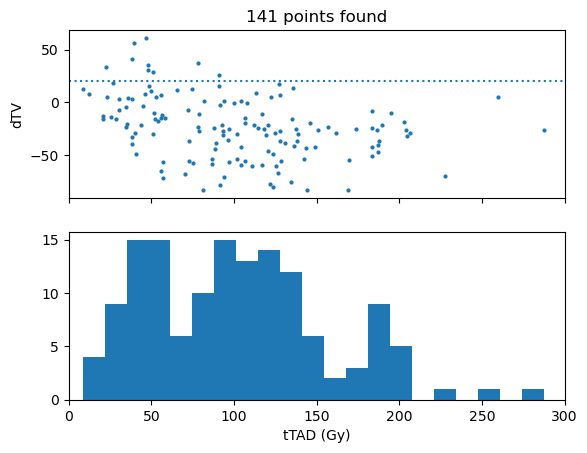

Class balance non-responder / responder: 33 108


In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from dev_utils_mc import *

points_x, points_y = load_dose_volume_points(plot=True)

x0 = points_x[points_y > 0]
x1 = points_x[points_y <= 0]
print("Class balance non-responder / responder:", len(x0), len(x1))

x = np.concatenate([x0, x1]).reshape(-1, 1) # tTAD
y = np.array([0] * len(x0) + [1] * len(x1)).reshape(-1, 1)


Fem punkter ble utelatt (146 i publikasjonen vs 141 ekstrahert), men synes figuren er visuelt lik Figur 3. Dosefordelingen ser kanskje litt anderledes ut (enn Figur 3B i publikasjonen), men det kan være at jeg ikke helt fant riktig bin-with. 

Respondere / ikke-respondere ble definert etter en terskel på dTV = 0, som definert for den logistiske regresjonen i figur 4 i stedet for dTV = 20% som tegnet i figur 3 (definert som stabil).

### Log-normal regresjon
To log-normale distribusjoner ble separat tilpasset dose-dataen for respondere / ikke-respondere. Ved visuell sammenlining er det litt forskjell mellom orginal og tilpasset log-normal, kanskje spesielt for ikke-respondere øverst. 


FITTING log-norm distributions with 33 and 108 observations
	params0= (0.5609514077081275, -10.383578920363496, 68.1739278419316)
	params1= (0.2171451699997102, -131.47333579774383, 236.68687462668657)
	MWU: 		p_orig=2.697e-05, p_drawn=3.401e-03
	T-test: 	p_orig=1.077e-04, p_drawn=3.672e-03
	difference fit vs drawn? p_mwu=0.2 / 0.6, p_ttest=0.4 / 0.7


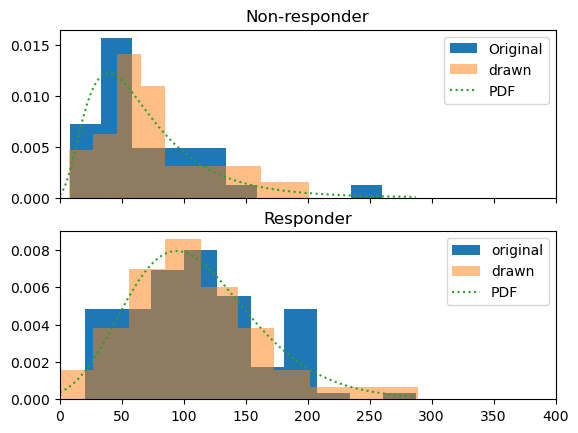

In [2]:
# Ndraw = None gir samme antall som for x0 og x1, for balansert sammenlikning.
x_sim0, x_sim1= fit_and_draw_lognorms(x0, x1, Ndraw=None, plot=True)

### Logistisk regresjon
Logistisk regresjon ble først brukt til å validere ekstraksjonen og log-normal distribusjonene, etter visuell sammenlikning med figur 4 i publikasjonen. 

En ikke-balansert variant (mtp antall observasjoner i responder / ikke-responder klassene) sammenliknes med en balansert variant, der den ikke-balanserte regresjonen er visuelt lik publikasjonen. 

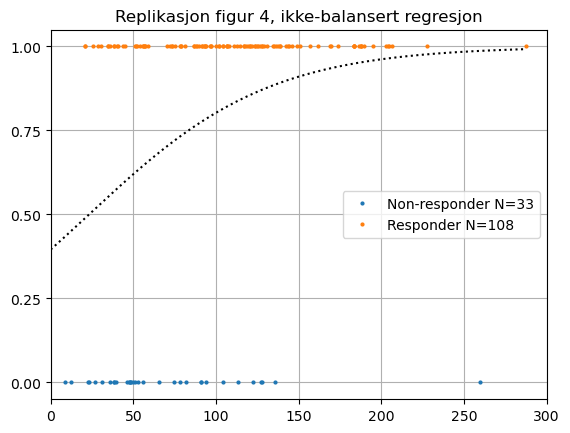

In [3]:
lr_orig = LogisticRegression(fit_intercept=True)
lr_orig.fit(x, y)

xvals_plot = np.linspace(0, np.max(x), 1000).reshape(-1, 1)
phat_plot_orig = lr_orig.predict_proba(xvals_plot)[:, -1]

phat_orig = lr_orig.predict_proba(x)[:, -1]

plot_doseresponse_with_lognorm(x0, x1, xvals_plot, phat_plot_orig, title="Replikasjon figur 4, ikke-balansert regresjon")

FITTING log-norm distributions with 33 and 108 observations
	params0= (0.5609514077081275, -10.383578920363496, 68.1739278419316)
	params1= (0.2171451699997102, -131.47333579774383, 236.68687462668657)
	MWU: 		p_orig=2.697e-05, p_drawn=0.000e+00
	T-test: 	p_orig=1.077e-04, p_drawn=0.000e+00
	difference fit vs drawn? p_mwu=1 / 1, p_ttest=0.9 / 0.9
	PPV=0.779, TPR=0.981, TNR=0.091, NPV=0.600, AUC=0.742, BS=0.155, ACC=0.773
	PPV=0.880, TPR=0.676, TNR=0.697, NPV=0.397, AUC=0.742, BS=0.210, ACC=0.681


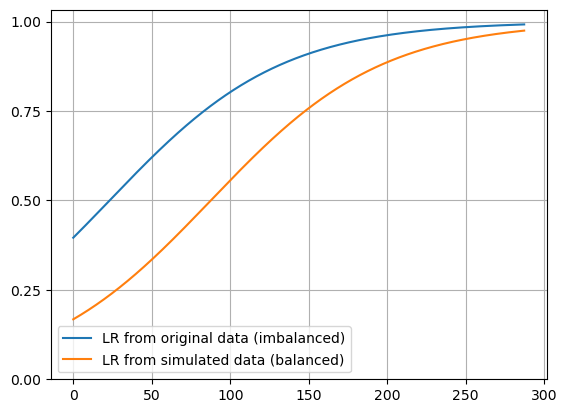

In [4]:
# Forsøker nå det samme med 10000 simulerte log-normal doser
x_sim0, x_sim1 = fit_and_draw_lognorms(x0, x1, Ndraw=10000, plot=False)
x_sim = np.concatenate([x_sim0, x_sim1]).reshape(-1, 1)
y_sim = np.array([0] * len(x_sim0) + [1] * len(x_sim1)).reshape(-1, 1)


lr_sim = LogisticRegression(fit_intercept=True)
lr_sim.fit(x_sim, y_sim)
phat_plot_sim = lr_sim.predict_proba(xvals_plot)[:, -1]

phat_sim = lr_sim.predict_proba(x)[:, -1]

get_logistic_prediction_scores(y, phat_orig, p_thresh=0.5)
get_logistic_prediction_scores(y, phat_sim, p_thresh=0.5)

plt.plot(xvals_plot, phat_plot_orig, label="LR from original data (imbalanced)")
plt.plot(xvals_plot, phat_plot_sim, label="LR from simulated data (balanced)")
plt.yticks([0, .25, .5, .75, 1])
plt.grid()
plt.legend()
plt.show()

Den systematiske forskjellen henger sammen med ubalansen i antall respodere / ikke-respondere for orginaldataen, da antall genererte punkter er likt for den simulerte dataen. Forskjellen forsvinner dersom dette tas høyde for i regresjonen til orginaldataen:

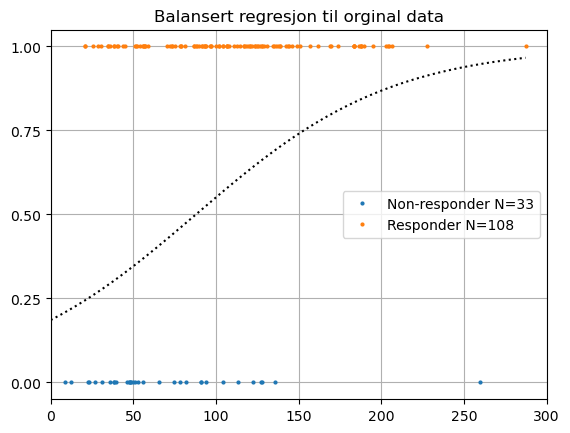

In [5]:
lr_orig_bal = LogisticRegression(fit_intercept=True, class_weight="balanced")
lr_orig_bal.fit(x, y)

xvals_plot = np.linspace(0, np.max(x), 1000).reshape(-1, 1)
phat_plot_orig = lr_orig_bal.predict_proba(xvals_plot)[:, -1]
phat_orig_bal = lr_orig_bal.predict_proba(x)[:, -1]

plot_doseresponse_with_lognorm(x0, x1, xvals_plot, phat_plot_orig, title="Balansert regresjon til orginal data")

FITTING log-norm distributions with 33 and 108 observations
	params0= (0.5609514077081275, -10.383578920363496, 68.1739278419316)
	params1= (0.2171451699997102, -131.47333579774383, 236.68687462668657)
	MWU: 		p_orig=2.697e-05, p_drawn=0.000e+00
	T-test: 	p_orig=1.077e-04, p_drawn=0.000e+00
	difference fit vs drawn? p_mwu=1 / 0.8, p_ttest=1 / 0.9
	PPV=0.779, TPR=0.981, TNR=0.091, NPV=0.600, AUC=0.742, BS=0.155, ACC=0.773
	PPV=0.880, TPR=0.676, TNR=0.697, NPV=0.397, AUC=0.742, BS=0.210, ACC=0.681


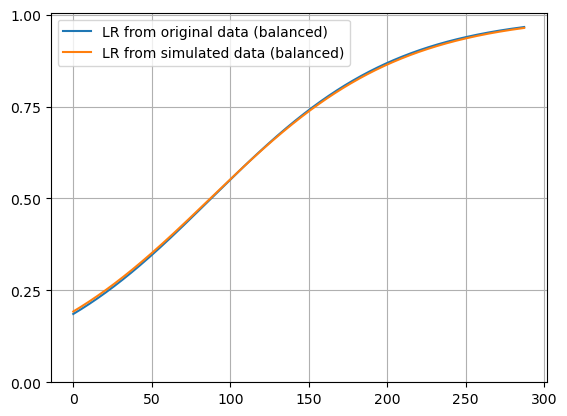

In [6]:
x_sim0, x_sim1 = fit_and_draw_lognorms(x0, x1, Ndraw=10000, plot=False)
x_sim = np.concatenate([x_sim0, x_sim1]).reshape(-1, 1)
y_sim = np.array([0] * len(x_sim0) + [1] * len(x_sim1)).reshape(-1, 1)


lr_sim_bal = LogisticRegression(fit_intercept=True, class_weight="balanced")
lr_sim_bal.fit(x_sim, y_sim)
phat_plot_sim = lr_sim_bal.predict_proba(xvals_plot)[:, -1]
phat_sim_bal = lr_sim_bal.predict_proba(x)[:, -1]

get_logistic_prediction_scores(y, phat_orig, p_thresh=0.5)
get_logistic_prediction_scores(y, phat_sim, p_thresh=0.5)

plt.plot(xvals_plot, phat_plot_orig, label="LR from original data (balanced)")
plt.plot(xvals_plot, phat_plot_sim, label="LR from simulated data (balanced)")
plt.yticks([0, .25, .5, .75, 1])
plt.grid()
plt.legend()
plt.show()

Som vist i figuren over konvergerer den logistiske regresjonen til det samme ved balanse i gruppeantallet, uavhengig om en tilpasser simulert data eller om det tas høyde for i selve regresjonen. 

In [12]:
print("Score på orginal ubalansert data:")
get_logistic_prediction_scores(y, phat_orig)
get_logistic_prediction_scores(y, phat_orig_bal)
get_logistic_prediction_scores(y, phat_sim)
get_logistic_prediction_scores(y, phat_sim_bal)

print(f"\nScore på simulert balansert data:")
get_logistic_prediction_scores(y_sim, lr_orig.predict_proba(x_sim)[:, -1])
get_logistic_prediction_scores(y_sim, lr_orig_bal.predict_proba(x_sim)[:, -1])
get_logistic_prediction_scores(y_sim, lr_sim.predict_proba(x_sim)[:, -1])
get_logistic_prediction_scores(y_sim, lr_sim_bal.predict_proba(x_sim)[:, -1])


Score på orginal ubalansert data:
	PPV=0.779, TPR=0.981, TNR=0.091, NPV=0.600, AUC=0.742, BS=0.155, ACC=0.773
	PPV=0.880, TPR=0.676, TNR=0.697, NPV=0.397, AUC=0.742, BS=0.210, ACC=0.681
	PPV=0.880, TPR=0.676, TNR=0.697, NPV=0.397, AUC=0.742, BS=0.210, ACC=0.681
	PPV=0.880, TPR=0.676, TNR=0.697, NPV=0.397, AUC=0.742, BS=0.209, ACC=0.681

Score på simulert balansert data:
	PPV=0.521, TPR=0.974, TNR=0.105, NPV=0.799, AUC=0.742, BS=0.264, ACC=0.539
	PPV=0.711, TPR=0.626, TNR=0.746, NPV=0.666, AUC=0.742, BS=0.210, ACC=0.686
	PPV=0.711, TPR=0.628, TNR=0.745, NPV=0.667, AUC=0.742, BS=0.210, ACC=0.686
	PPV=0.711, TPR=0.631, TNR=0.744, NPV=0.668, AUC=0.742, BS=0.210, ACC=0.687


(0.7111612175873732,
 0.6308,
 0.7438,
 0.6682839173405211,
 0.74204716,
 0.21037838672831957,
 0.6873)

Ubalansert logistisk regresjon til orginaldata (som fra Figur 4 i publikasjonen) har en høyere accuracy, sensitivitet (TPR, power) og NPV enn den balanserte varianten evaluert på orginal data (som den er tilpasset). Men selv her er spesifisiteten (TNR) ekstremt lav, og lavere enn for den balanserte varianten, mest sannsynlig på bekostning av den høye sensitiviteten. 
Generelt er det er små forskjeller i skåringer mellom evaluering på ekte og simulert data, for alle modeller.



# Estimering av populasjonsstørrelse

De to tilpassede log-normale fordelingene kan brukes til å analytisk estimere minimum populasjonsstørrelse for å oppnå en viss statistisk power (1 - sannsynlighet for type II feil = 1 - $\beta$) gitt en satt terskel på sannsynlighet for type I feil ($\alpha$, feks 0.05). Her sammenliknes en analytisk og to simulerings-baserte tilnærminger: en monte-carlo metode ved bruk av log-normal fordelinger, og en ved bruk av reperert undermengde-sampling med tilbakelegging (en slags subset-bootstrap).

### Analytisk tilnærming

Kilde: Kapittel 14 i boka "Dose finding in drug development", Neitee Ting, 2006, Springer New York, https://doi.org/10.1007/0-387-33706-7

$\LARGE N_1=\frac{(z_{1-\alpha} \sigma_0 + z_{1-\beta} \sigma_a)^2}{(1 + 1/r)^{-1} \epsilon^2}$

Der
- $\epsilon$ er effektstørrelsen (feks forskjell i gjennomsnitt)
- $z_{1-\alpha}$ og $z_{1-\beta}$ er de kritiske verdiene tilhørende standard normalfordelingen (som brukes pga sentralgrenseteoremet)
- $\sigma$ er standardavviket for de to gruppene
- $r = n_2 / n_1$ er forholdet mellom populasjonsmengdene i gruppene som sammenliknes

In [ ]:
from scipy.stats import norm, lognorm


za = norm.ppf(q=0.975, loc=0, scale=1)   # alpha = 0.05 (one-tailed)
# zb = norm.ppf(q=0.95, loc=0, scale=1)    # beta = 0.10 (-> power = 0.9)
zb = norm.ppf(q=0.90, loc=0, scale=1)    # beta = 0.20 (-> power = 0.8)

# za = norm.ppf(q=0.95, loc=0, scale=1)   # alpha = 0.05 (two-tailed)
# zb = norm.ppf(q=0.90, loc=0, scale=1)    # beta = 0.10 (-> power = 0.9)


# n_func = lambda s0, s1, eps2: np.ceil((s0*za + s1*zb)**2 / eps2)
n_func = lambda s0, s1, eps2, r=1: np.ceil((s0*za + s1*zb)**2 / ((1 + 1/r)**(-1) * eps2))

print("Estimert minimum populasjonsstørrelse N_1 (per gruppe?) gitt likt antall observasjoner per gruppe")

s0, s1, eps2 = np.std(x0), np.std(x1), (np.mean(x0)-np.mean(x1))**2
print("\toriginal data: N = ", n_func(s0, s1, eps2))

s0, s1, eps2 = np.std(np.log(x0)), np.std(np.log(x1)), (np.mean(np.log(x0))-np.mean(np.log(x1)))**2
print("\tlog-transformert data: N = ", n_func(s0, s1, eps2))


r = len(x0) / len(x1)

print(f"\nGitt samme forholdstall mellom respondere / ikke-respondere som i Hebert et al 2024 (r = {len(x0)} / {len(x1)} = {r:.1f})")

s0, s1, eps2 = np.std(x0), np.std(x1), (np.mean(x0)-np.mean(x1))**2
print("\toriginal data: N = ", n_func(s0, s1, eps2, r))

s0, s1, eps2 = np.std(np.log(x0)), np.std(np.log(x1)), (np.mean(np.log(x0))-np.mean(np.log(x1)))**2
print("\tlog-transformert data: N = ", n_func(s0, s1, eps2, r))


# TODO: bruke underliggende gaussisk kurve til log-normal tilpasning i estimat?
# Get log-norm parameters from fit
# p0, p1 = fit_and_draw_lognorms(x0, x1, return_params=True, verbose=False, evaluate=False)
# x_sim0, x_sim1 = fit_and_draw_lognorms(x0, x1, Ndraw=10000, return_params=False, verbose=False, evaluate=False)

# s0, s1 = p0[0], p1[0]   # sd -> same for underlying gaussian?
# lc0, lc1 = p0[1], p1[1] # location (shift) parameter
# sc0, sc1 = p0[2], p1[2] # scale parameter = exp(mean) of gaussian
# mu0, mu1 = np.log(sc0), np.log(sc1)

# print("Mean in log-norm space:", lognorm.mean(*p0), lognorm.mean(*p1))
# print(np.exp(mu0 + s0**2/2) + lc0, np.exp(mu1 + s1**2/2) + lc1) # = means of log-norm distributions in sample space

# print("Mean of gaussian:", end=" ")
# print(np.mean(np.log(x0)), np.mean(np.log(x1)))
# print(np.log(sc0 + lc0), np.log(sc1 + lc1))



### Monte-carlo simulering av FPR / TPR


Loaded p-vals: (146000, 5)
Calculated TPR: (146, 3)


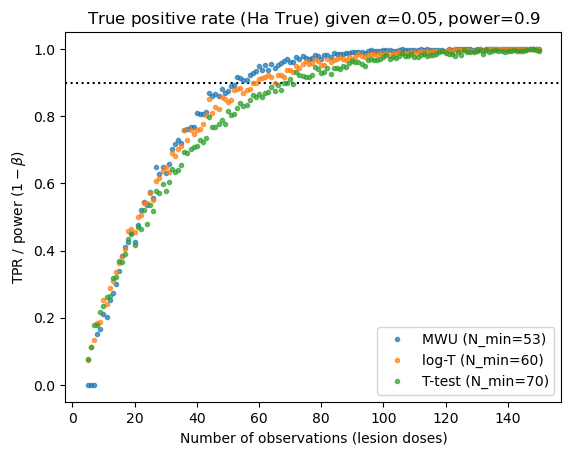

In [9]:
from scipy.stats import lognorm
savename = f"mc_hebert2024.csv"

# TODO: random subset sampling instead of MC -> does log-statistical test perform equal-ish to log-normal simulated data?
# TODO: include logistic regression p-value (thresh -> dich outcome -> chisq?)
p0, p1 = fit_and_draw_lognorms(x0, x1, return_params=True, verbose=False, evaluate=False)

monte_carlo_sample_size_calculate(sample_func=lognorm.rvs, params_0=p0, params_1=p1, Nmax=50, num_repeat=1000, shuffle=False, savename=savename)

monte_carlo_sample_size_analyze_typeII(savename, alpha=0.05, power=0.9)


Loaded p-vals: (195000, 3)
Calculated TPR: (195, 2)


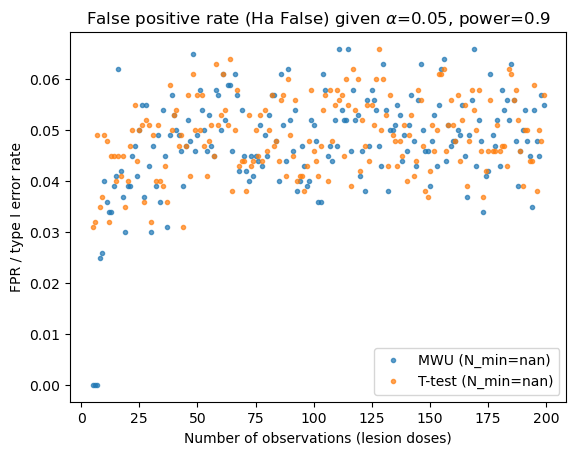

In [10]:
savename = f"mc_hebert2024_shuff.csv"
monte_carlo_sample_size_calculate(sample_func=lognorm.rvs, params_0=p0, params_1=p1, Nmax=200, num_repeat=1000, shuffle=True, savename=savename)
monte_carlo_sample_size_analyze_typeII(savename, alpha=0.05, power=0.9)


### Repeated subset sampling
Alternativ simulering uten noe antagelser om eller tilpasninger av distribusjoner, kun bruk av rådata. 
Trekker en undermengde av orginal data med tilbakelegging (i.e. en slags subset bootstrap), og estimerer TPR som for Monte-carlo simuleringen.

Det ble beregnet to versjoner, der forholdet mellom antallet i hver klasse ble holdt konstant (med stratifisering) og ikke (tilfeldig forholdstall per repetisjon).


Loaded p-vals: (134000, 4)
Calculated TPR: (134, 3)


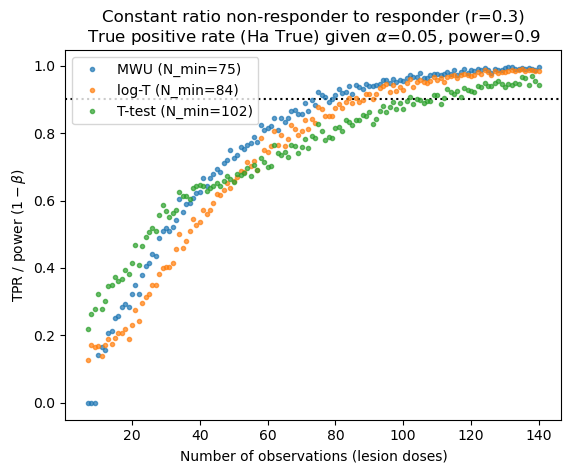

Loaded p-vals: (131938, 4)
Calculated TPR: (136, 3)


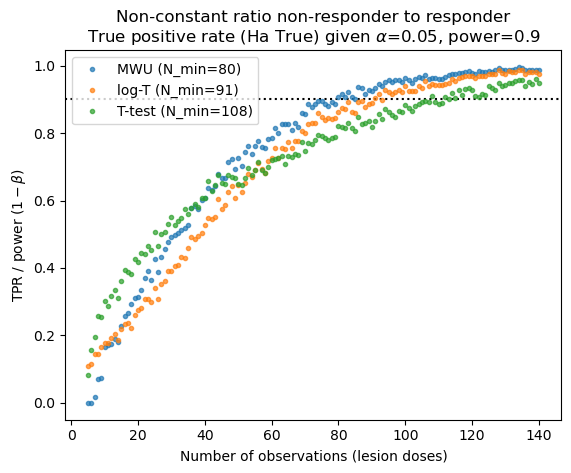

In [11]:
savename = f"rsb_hebert2024_strat=True.csv"
# repeated_bootstrap_samplesize_calculate(x, y, num_repeat=1000, stratify=False, shuffle=False, savename=savename)
monte_carlo_sample_size_analyze_typeII(savename, alpha=0.05, power=0.9, title=f"Constant ratio non-responder to responder (r={len(x0) / len(x1):.1f})")

savename = f"rsb_hebert2024_strat=False.csv"
# repeated_bootstrap_samplesize_calculate(x, y, num_repeat=1000, stratify=False, shuffle=False, savename=savename)
monte_carlo_sample_size_analyze_typeII(savename, alpha=0.05, power=0.9, title="Non-constant ratio non-responder to responder")